<a href="https://colab.research.google.com/github/Nedu21/Keras-deep-learning-projects/blob/last/TextSentiment_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Text sentiment classifier
- Goal: Build a ML model that takes in a movie review and predicts whether the review is +ve or -ve.
- Dataset to be used: IMDB movie reviews.
- Model choice: Transformer

## Make necessary imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import TextVectorization, GlobalAveragePooling1D, Embedding
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, MultiHeadAttention, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds
import tensorflow as tf

# Data Preprocessing

## Loading the data

In [2]:
# Load the data
train_ds, val_ds, test_ds = tfds.load(
    name="imdb_reviews",
    split=(
          'train[:80%]', # Training set (80% of otiginal train set)
          'train[80%:]', # Val set (remaining 20% of the original train set)
          'test' # The provided test set in the dataset
           ),
    as_supervised=True,
    shuffle_files=True
)

# Then shuffle train
train_ds = train_ds.shuffle(10000, seed=42)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.JAC1FI_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.JAC1FI_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.JAC1FI_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Text Vectorization

**TextVectorization** from keras layers is a layer that:
- Cleans the text (optional)
- Tokenizes it (splits into words or characters)
- Converts words to integers or other formats
- Outputs something your model can use

Add **hyperparameters**

In [3]:
# Hyperparameters
VOCAB_SIZE = 10000      # vocab size
SEQ_LEN = 200           # pad/truncate reviews to 200 tokens
EMBED_DIM = 128         # embedding size (reduced from 256)
BATCH_SIZE = 16         # Reduced from 32
NUM_HEADS = 8
FF_DIM = 256            # 2x embed_dim (reduced from 512)
NUM_CLASSES = 1         # binary classification

In [4]:
# Create vectorization layer
vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int', # Controls what the layer outputs
    output_sequence_length=SEQ_LEN
)

# Adapt the layer to your training text
# Use only the text part from train_ds
text_ds = train_ds.map(lambda text, label: text)
vectorizer.adapt(text_ds)

# Apply the vectorizer to the text_ds
vectorized_text = text_ds.map(lambda text: vectorizer(text))

## Perform Embedding & Add Positional Encoding on vectorized texts
ie Position information is added to embeddings so the model knows word order

In [5]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
      super().__init__()
        # Create an embedding layer
      self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Create a position embedding layer
      self.position_emb = Embedding(input_dim=sequence_length, output_dim=embed_dim)
      self.sequence_length = sequence_length

    def call(self, inputs):
      batch_size = tf.shape(inputs)[0]
      length = tf.shape(inputs)[-1]

      positions = tf.range(start=0, limit=self.sequence_length, delta=1)
      positions = tf.expand_dims(positions, 0)
        # Duplicates your position indices across the entire batch
      positions = tf.tile(positions, [batch_size, 1])

      embedded_tokens = self.token_emb(inputs)
      embedded_positions = self.position_emb(positions)
      return embedded_tokens + embedded_positions

In [6]:
# Apply inside dataset
positional_text = vectorized_text.batch(BATCH_SIZE).map(
    PositionalEmbedding(SEQ_LEN, VOCAB_SIZE, EMBED_DIM)
    )

# Check a sample
for sample in positional_text.take(1):
    print(sample.shape)   # should be (batch_size, MAX_LEN, EMBED_DIM)

(16, 200, 128)


# Building the Transformer Model

## Build the transformer block

In [7]:
class TransformerBlock(Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.2):
    super().__init__()
    self.att = MultiHeadAttention(num_heads=num_heads, key_dim=(embed_dim // num_heads))
    self.ffn = Sequential([
        Dense(ff_dim, activation='relu'),
        Dropout(dropout_rate), #(Added this to try reduce overfitting)
        Dense(embed_dim)
    ])
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(dropout_rate)
    self.dropout2 = Dropout(dropout_rate)

  def call(self, inputs, training=None):
    attn_output = self.att(inputs, inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)

## Build the model

In [8]:
# Create the model architecture
inputs = Input(shape=(SEQ_LEN,))

# Add positional encoding
x = PositionalEmbedding(SEQ_LEN, VOCAB_SIZE, EMBED_DIM)(inputs)

# Apply Transformer Block(s) - you can stack multiple blocks
x = TransformerBlock(EMBED_DIM, num_heads=4, ff_dim=128, dropout_rate=0.1)(x)
x = TransformerBlock(EMBED_DIM, num_heads=4, ff_dim=128, dropout_rate=0.1)(x)

# Global pooling to get fixed-size representation (GAP1D is used for sequential data (text, time series, audio))
x = GlobalAveragePooling1D()(x)

# Add dropout after GAP
x = Dropout(0.5)(x)

# Add an extra dense layer
x = Dense(64, activation='relu')(x)

# Add dropout before final layer
x = Dropout(0.5)(x)

# Output layer
# For binary classification:
outputs = Dense(NUM_CLASSES, activation='sigmoid')(x)
# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# View model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_1          │ (None, 200, 128)       │     1,305,600 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 128)       │        99,584 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 128)       │        99,584 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,513,089 (5.77 MB)

 Trainable params: 1,513,089 (5.77 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

In [9]:
model.compile(
    optimizer= Adam(
    learning_rate=0.0005,
    clipnorm=1.0  # Clips gradients to prevent explosions
),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Train the model with early stopping and save best weights with model checkpoints

In [17]:
# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)

# Now you need to prepare your training and validation data with labels
# Your train_ds and val_ds are already loaded and are (text, label) pairs
# You need to apply the same preprocessing (vectorization)
# and batching to both train_ds and val_ds

# Apply vectorization and positional embedding to the training data
train_data = train_ds.map(
    lambda text, label: (vectorizer(text), label)
).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Apply vectorization and positional embedding to the validation data
val_data = val_ds.map(
    lambda text, label: (vectorizer(text), label)
).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the model with callbacks
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[early_stopping]
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8903 - loss: 0.2880 - val_accuracy: 0.8654 - val_loss: 0.3224
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9298 - loss: 0.1940 - val_accuracy: 0.8522 - val_loss: 0.4058
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9511 - loss: 0.1480 - val_accuracy: 0.8504 - val_loss: 0.4484
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9656 - loss: 0.1087 - val_accuracy: 0.8436 - val_loss: 0.5663
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9749 - loss: 0.0861 - val_accuracy: 0.8386 - val_loss: 0.6617
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9807 - loss: 0.0628 - val_accuracy: 0.8410 - val_loss: 0.6878


# Plot train/val loss, acc and LR to understand what happened

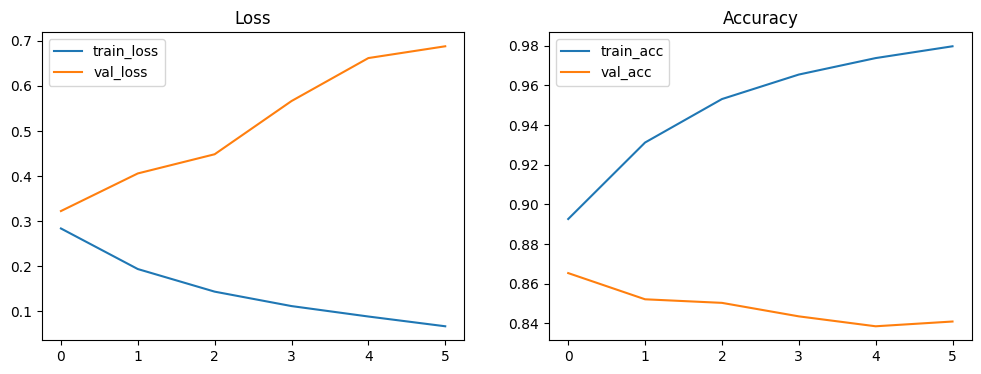

In [18]:
hist = history.history

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(hist['accuracy'], label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Test the model with test data and randomly generated data

## Using the test data

In [19]:
test_data = test_ds.map(
    lambda text, label: (vectorizer(text), label)
).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

results = model.evaluate(test_data, verbose=1)
print("Test results (loss, accuracy):", results)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8492 - loss: 0.3485
Test results (loss, accuracy): [0.34756535291671753, 0.8496800065040588]


## Nedu's review 😌

In [20]:
review = "That movie was really bad. That's two hours i'll never get back."
threshold = 0.5  # classification threshold for sigmoid output

# 1) Vectorize (TextVectorization layer)
vec = vectorizer(tf.constant([review]))   # returns shape (1, SEQ_LEN), dtype int32

# 2) Predict (model expects ints)
proba = model.predict(vec)[0, 0]          # scalar probability (0..1)

label = int(proba >= threshold)
label_text = "positive" if label == 1 else "negative"

print(f"probability: {proba:.4f}, label: {label} ({label_text})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
probability: 0.0216, label: 0 (negative)


## Kenechi's review 😬

In [21]:
review = '''The movies cast performed theatrically well. I was moved by each of the lines that were delivered by each member
            of the cast and I remained immersed throughout the movie screening, however the cgi used during some parts of
            the movie were underwhelming. Unfortunately, the cgi and other visual effects didn't do justice to the
            wonderful performance delivered by the cast.'''
threshold = 0.5  # classification threshold for sigmoid output

# 1) Vectorize (TextVectorization layer)
vec = vectorizer(tf.constant([review]))   # returns shape (1, SEQ_LEN), dtype int32

# 2) Predict (model expects ints)
proba = model.predict(vec)[0, 0]          # scalar probability (0..1)

label = int(proba >= threshold)
label_text = "positive" if label == 1 else "negative"

print(f"probability: {proba:.4f}, label: {label} ({label_text})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
probability: 0.8907, label: 1 (positive)


## AI generated review 😒

In [22]:
review = '''Beautifully shot and the lead gives a handful of genuinely warm moments that almost sell the film,
            and the score is lovely. But the plot collapses into lazy clichés, the second half drags, and by
            the end I was more annoyed than moved.'''
threshold = 0.5  # classification threshold for sigmoid output

# 1) Vectorize (TextVectorization layer)
vec = vectorizer(tf.constant([review]))   # returns shape (1, SEQ_LEN), dtype int32

# 2) Predict (model expects ints)
proba = model.predict(vec)[0, 0]          # scalar probability (0..1)

label = int(proba >= threshold)
label_text = "positive" if label == 1 else "negative"

print(f"probability: {proba:.4f}, label: {label} ({label_text})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
probability: 0.7654, label: 1 (positive)


In [23]:
review = '''The visuals are polished and there’s a quiet confidence in the direction that’s hard to ignore,
            and the score, while understated, fits the mood. But the emotional arc feels oddly flat, and just
            when it seems to build momentum, it slips into something that feels familiar and unearned.'''
threshold = 0.5  # classification threshold for sigmoid output

# 1) Vectorize (TextVectorization layer)
vec = vectorizer(tf.constant([review]))   # returns shape (1, SEQ_LEN), dtype int32

# 2) Predict (model expects ints)
proba = model.predict(vec)[0, 0]          # scalar probability (0..1)

label = int(proba >= threshold)
label_text = "positive" if label == 1 else "negative"

print(f"probability: {proba:.4f}, label: {label} ({label_text})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
probability: 0.8727, label: 1 (positive)
